In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
import prep
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

wrangle.py functions loaded successfully
acquire.py functions loaded successfully


# Import Prepared Zillow Data

In [2]:
## Assigning function
df = prep.prep_zillow_data()
## Checking for nulls
df.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
propertylandusetypeid           0
dtype: int64

In [3]:
## Applying our train_validate_test function to the dataframe to split and remove unneeded features for the models
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test(df)

In [4]:
## Applying scaler to scale our data
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test)

In [5]:
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
9313,0.25,0.166667,0.166667,0.173552,0.111111
1308,0.20,0.250000,0.111111,0.256174,0.111111
11475,0.20,0.333333,0.111111,0.358643,0.111111
16038,0.30,0.250000,0.222222,0.376875,0.222222
1198,0.10,0.083333,0.000000,0.156935,0.000000


# KBest
- Here we're going to run all the features through our k best and return only the 5 best ones for our model

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
f_selector = SelectKBest(f_regression, k=5)

In [8]:
## we are running the scaled train data through kbest
f_selector = f_selector.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [9]:
## Transforming the data
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(11746, 5)
(11746, 5)


In [10]:
f_support = f_selector.get_support()
f_support

array([ True,  True,  True,  True,  True])

In [11]:
## Listing out the features so we can see which ones were returned
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt']

In [12]:
## Returning a scaled dataframe with only our best features
X_reduced_scaled = X_train_scaled.iloc[:, f_support]
X_reduced_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
9313,0.25,0.166667,0.166667,0.173552,0.111111
1308,0.20,0.250000,0.111111,0.256174,0.111111
11475,0.20,0.333333,0.111111,0.358643,0.111111
16038,0.30,0.250000,0.222222,0.376875,0.222222
1198,0.10,0.083333,0.000000,0.156935,0.000000


# Takeaways
- The features that were selected were relatively consistent with our intial thoughts
- We anticipated that the bedroom count and square footage of the property would be important

# Recursive Feature Elimination
- Here we wanted to compare the RFE to KBest since RFE is typically more accurate
- We're keeping the K at 5 just to ensure consistency

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [14]:
## Assessing the RFE using a linear regression model
lm = LinearRegression()

rfe = RFE(lm, 5)

lm_X_rfe = rfe.fit_transform(X_train,y_train) 

In [15]:
## Here we want to filter through and return only the best features
mask = rfe.support_ 
rfe_features = X_train.columns[mask]
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


# RFE Takeaways
- It appears that our RFE and KBest came to the same conclusion about our best features to use
- This will strengthen our argument when discussing best features to assess the model on

# Linear Regression Model - Training The Model

In [16]:
lm.fit(lm_X_rfe, y_train)

LinearRegression()

In [17]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [44807.1713353]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt'],
      dtype='object')
coefficients:  [[ 129714.6420099  -108982.63989217  -26781.71316692     339.57650261
   -31021.79859825]]


In [18]:
## Here we're going to add a column that will make property value predictions using the linear model
y_train['yhat_lm'] = lm.predict(lm_X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
9313,222641.0,379365.097212
1308,261391.0,340484.380834
11475,427992.0,382273.708102
16038,176043.0,589994.021946
1198,503743.0,340520.634249


In [19]:
## Checking the mean squared error of the model
RMSE_lm = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_lm))
RMSE_lm

387621.87590380665

In [20]:
r2_lm = lm.score(lm_X_rfe, y_train.taxvaluedollarcnt)

r2_lm

0.29686157496714216

In [21]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = 4.481e+04 + 1.3e+05 * bathroomcnt + -1.09e+05 * bedroomcnt'

# Linear Regression Model - Validating The Model
- We came back and added the validate beneath the training just to maintain continuity and easier performance comparison

In [22]:
lm_X_rfe = rfe.fit_transform(X_validate,y_validate)
mask = rfe.support_ 
rfe_features = X_validate.columns[mask]
## Verifying same features returned as train
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


In [23]:
## Same process as above, just with validate
y_validate['yhat_lm'] = lm.predict(lm_X_rfe).round(1)

y_validate.head()

,taxvaluedollarcnt,yhat_lm
7557,294232.0,170096.1
111,203113.0,570356.3
7759,592933.0,236595.4
10968,785799.0,1078459.2
14557,381637.0,286152.1


In [24]:
RMSE_lm = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_lm))
RMSE_lm

396767.3522806633

In [25]:
r2_lm = lm.score(lm_X_rfe, y_validate.taxvaluedollarcnt)

r2_lm

0.28081357670979523

In [26]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = 4.481e+04 + 1.3e+05 * bathroomcnt + -1.09e+05 * bedroomcnt'

# Baseline Model vs Linear Regression

462262.2248865707
-2.220446049250313e-16


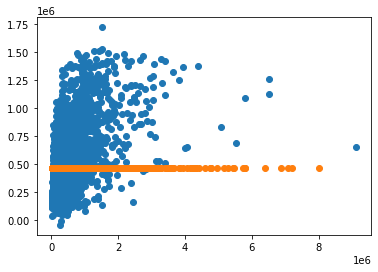

In [27]:
y_train['yhat_baseline'] = df['taxvaluedollarcnt'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_baseline))
print(RMSE_bl)

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.yhat_baseline)
print(evs)
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

# Takeaways
- Our Linear Model is performing better than the baseline based on this graph, but we will want to compare it below to the Polynomial so we can get our MVP

# Polynomial Regression Model At 4 Degrees

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly_X_rfe = rfe.fit_transform(X_train,y_train)

## We're starting with 4 degrees as a rough starting point
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(poly_X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x4^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x4^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x4^2',
 'x3^3',
 'x3^2 x4',
 'x3 x4^2',
 'x4^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^3 x3',
 'x0^3 x4',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x1 x3',
 'x0^2 x1 x4',
 'x0^2 x2^2',
 'x0^2 x2 x3',
 'x0^2 x2 x4',
 'x0^2 x3^2',
 'x0^2 x3 x4',
 'x0^2 x4^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1^2 x3',
 'x0 x1^2 x4',
 'x0 x1 x2^2',
 'x0 x1 x2 x3',
 'x0 x1 x2 x4',
 'x0 x1 x3^2',
 'x0 x1 x3 x4',
 'x0 x1 x4^2',
 'x0 x2^3',
 'x0 x2^2 x3',
 'x0 x2^2 x4',
 'x0

- Here were going to create a column and return all the predictions for the first polynomial model
- Then were going to compare it to the linear regression model and baseline

In [29]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_1'] = lm_poly.predict(X_poly)

In [30]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_1))
RMSE_poly

386753.4785654679

In [31]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1
9313,222641.0,379365.097212,467226.149259,336428.220108
1308,261391.0,340484.380834,467226.149259,367696.962514
11475,427992.0,382273.708102,467226.149259,428068.817825
16038,176043.0,589994.021946,467226.149259,567505.674529
1198,503743.0,340520.634249,467226.149259,208487.975253


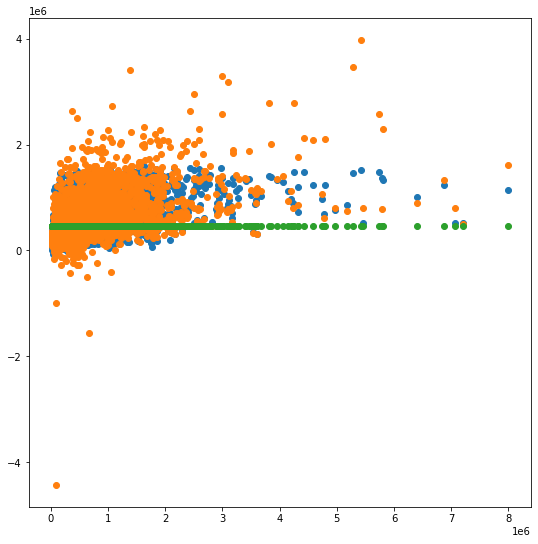

In [32]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_poly_1, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

# Takeaways
- Both models were performing better than baseline but based on the points, the polynomial is actually going to be closest to that perfect 45 degree angle of the regression line
- At this point it's safe to assume that the Polynomial is going to be the right model to further build on with different versions of this model

# Polynomial Regression Model At 3 Degrees

In [33]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(poly_X_rfe)

In [34]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_2'] = lm_poly.predict(X_poly)

In [35]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_2))
RMSE_poly

378429.68233185686

In [36]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1,yhat_poly_2
9313,222641.0,379365.097212,467226.149259,336428.220108,303945.664603
1308,261391.0,340484.380834,467226.149259,367696.962514,333908.039083
11475,427992.0,382273.708102,467226.149259,428068.817825,370336.042247
16038,176043.0,589994.021946,467226.149259,567505.674529,578380.619043
1198,503743.0,340520.634249,467226.149259,208487.975253,313459.856424


# Polynomial Regression Model At 2 Degrees

In [37]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(poly_X_rfe)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_3'] = lm_poly.predict(X_poly)
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_3))
RMSE_poly

380409.4558204644

In [38]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1,yhat_poly_2,yhat_poly_3
9313,222641.0,379365.097212,467226.149259,336428.220108,303945.664603,304556.562718
1308,261391.0,340484.380834,467226.149259,367696.962514,333908.039083,335456.387157
11475,427992.0,382273.708102,467226.149259,428068.817825,370336.042247,382108.035361
16038,176043.0,589994.021946,467226.149259,567505.674529,578380.619043,560286.528744
1198,503743.0,340520.634249,467226.149259,208487.975253,313459.856424,306672.033139


In [39]:
y_train['base_perc_error'] = ((y_train.taxvaluedollarcnt - y_train.yhat_baseline) / y_train.taxvaluedollarcnt) * 100
y_train.base_perc_error.sum()

-1286457.5597519297

# Takeaways
- After assessing different degrees for the polynomial model, it appears that the model set to 4 and 3 degrees are pretty similar so we will run both against the validate compared to linear

# Polynomial Regression Model On Validate Set

In [40]:
val_poly_X_rfe = rfe.fit_transform(X_validate,y_validate) 

In [41]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(val_poly_X_rfe)

In [42]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate.taxvaluedollarcnt)
y_validate['yhat_poly1'] = lm_poly.predict(X_poly).round(1)

In [43]:
RMSE_poly = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_poly1))
RMSE_poly

382637.3800996755

In [44]:
y_validate.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly1
7557,294232.0,170096.1,284167.8
111,203113.0,570356.3,566428.2
7759,592933.0,236595.4,287559.1
10968,785799.0,1078459.2,1182784.4
14557,381637.0,286152.1,285552.2


In [45]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(val_poly_X_rfe)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate.taxvaluedollarcnt)
y_validate['yhat_poly2'] = lm_poly.predict(X_poly).round(1)
RMSE_poly = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_poly2))
RMSE_poly

385883.9830001233

In [46]:
y_validate.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly1,yhat_poly2
7557,294232.0,170096.1,284167.8,276173.4
111,203113.0,570356.3,566428.2,538410.5
7759,592933.0,236595.4,287559.1,288938.0
10968,785799.0,1078459.2,1182784.4,1103422.6
14557,381637.0,286152.1,285552.2,293323.6


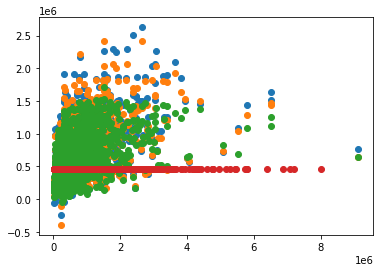

In [47]:
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_poly1, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_poly2, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

# Linear vs Poly On Validate
- After comparing the 4 models on the validate datasets, the model set to 4 degrees is the best one because it improved on the validate, where the model at 3 degrees did not
- Polynomial at 4 degress is our MVP

# MVP - Poly At Degree 4

In [48]:
test_poly_X_rfe = rfe.fit_transform(X_test,y_test) 

In [49]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(test_poly_X_rfe)

In [50]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_test.taxvaluedollarcnt)
y_test['yhat_poly'] = lm_poly.predict(X_poly).round(1)

In [51]:
RMSE_poly = np.sqrt(mean_squared_error(y_test.taxvaluedollarcnt, y_test.yhat_poly))
RMSE_poly

418205.3073422054

In [52]:
y_test.head()

,taxvaluedollarcnt,yhat_poly
16254,323000.0,311548.8
19572,489857.0,409372.9
1631,406174.0,351784.7
12252,96661.0,495246.2
2736,68910.0,302473.1


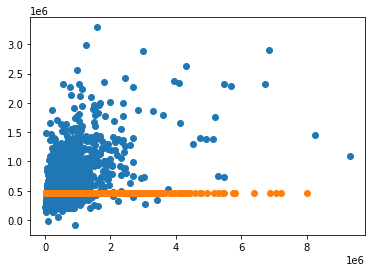

In [53]:
plt.scatter(y_test.taxvaluedollarcnt, y_test.yhat_poly, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

In [54]:
y_test['perc_error'] = ((y_test.taxvaluedollarcnt - y_test.yhat_poly) / y_test.taxvaluedollarcnt) * 100
y_test

,taxvaluedollarcnt,yhat_poly,perc_error
16254,323000.0,311548.8,3.545263
19572,489857.0,409372.9,16.430121
1631,406174.0,351784.7,13.390640
12252,96661.0,495246.2,-412.353690
2736,68910.0,302473.1,-338.939341
...,...,...,...
5130,1076164.0,1117762.5,-3.865442
13785,332000.0,221345.2,33.329759
3405,408000.0,214797.1,47.353652
14824,572000.0,529881.7,7.363339


In [55]:
print('MVP error',(y_test.perc_error.sum()).round(2))
print('Baseline error:',(y_train.base_perc_error.sum()).round(2))
print('Our model had', (y_train.base_perc_error.sum() / y_test.perc_error.sum()).round(1), 'times less error than baseline')

MVP error -277759.98
Baseline error: -1286457.56
Our model had 4.6 times less error than baseline


# Final Thoughts
- None of these models would be what I would consider accurate if we account for the massive variance in property valuations in this area, however, our model did significantly beat the baseline
- Now that we have a good solid foundation with key features to take into account, we can look deeper at collecting additional data so we can create models that will predict property values by county rather than the area as a whole